C:\Users\33615\AppData\Local\Temp\ipykernel_30240\2733367239.py:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('stock_code').apply(process_group).reset_index(drop=True)


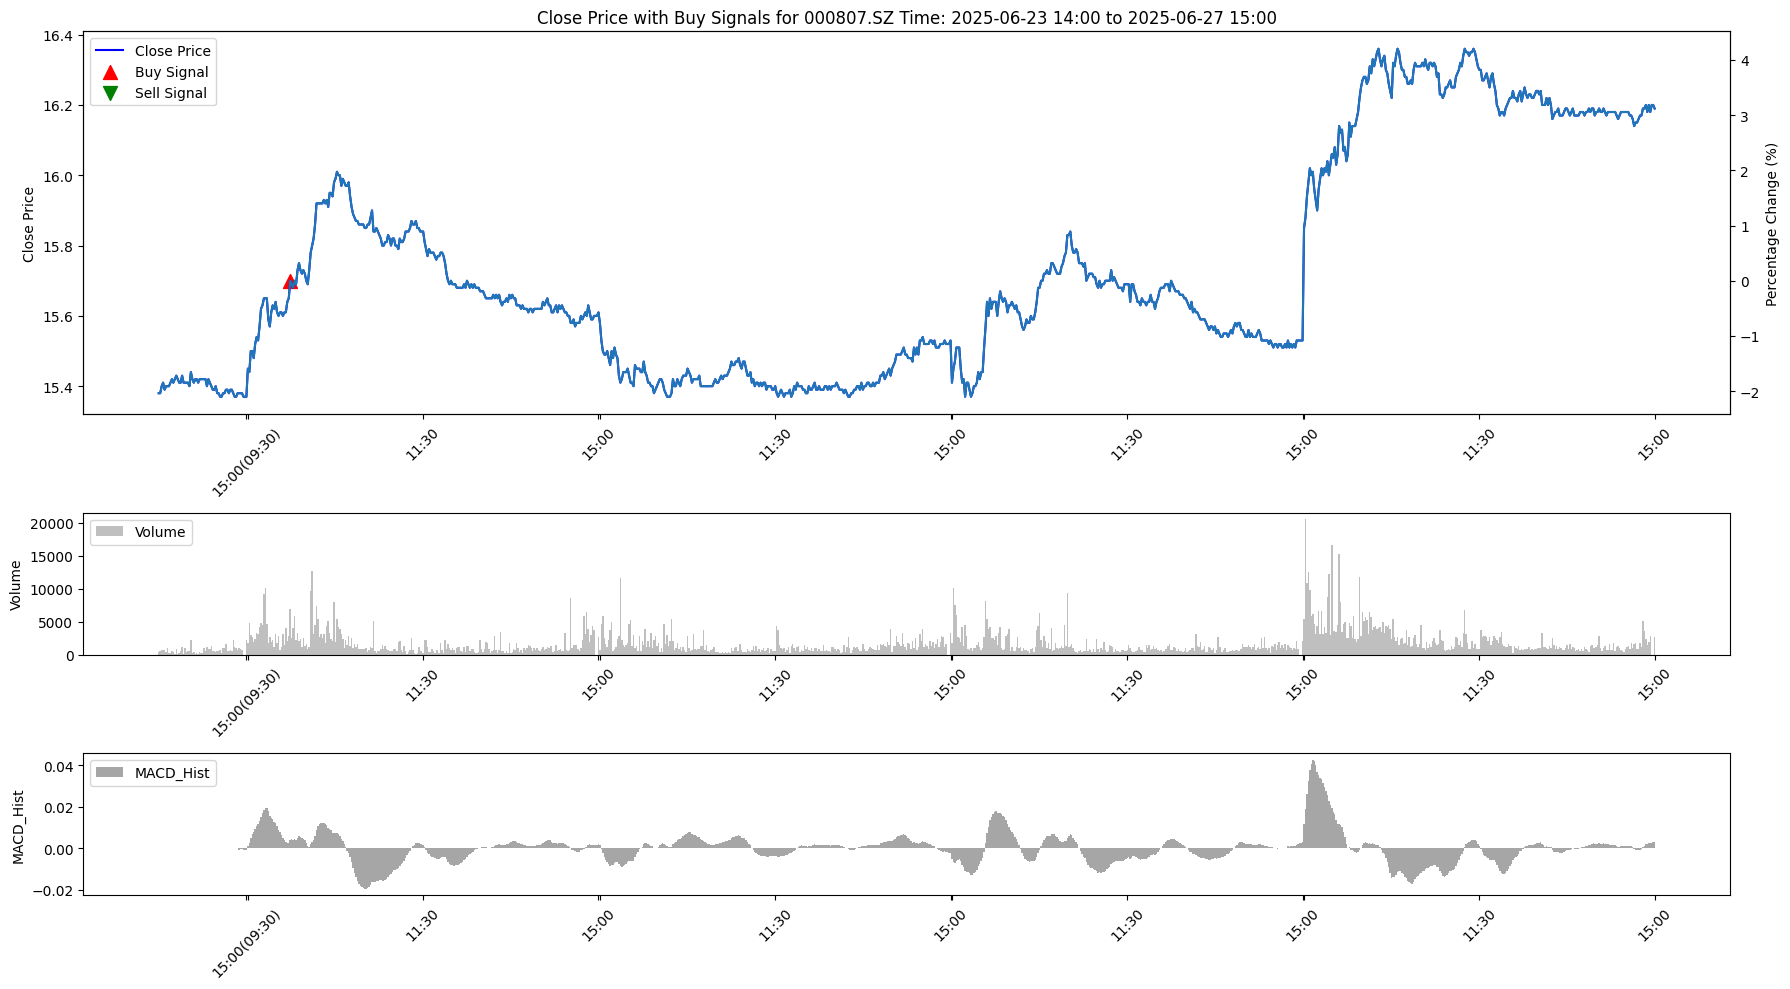

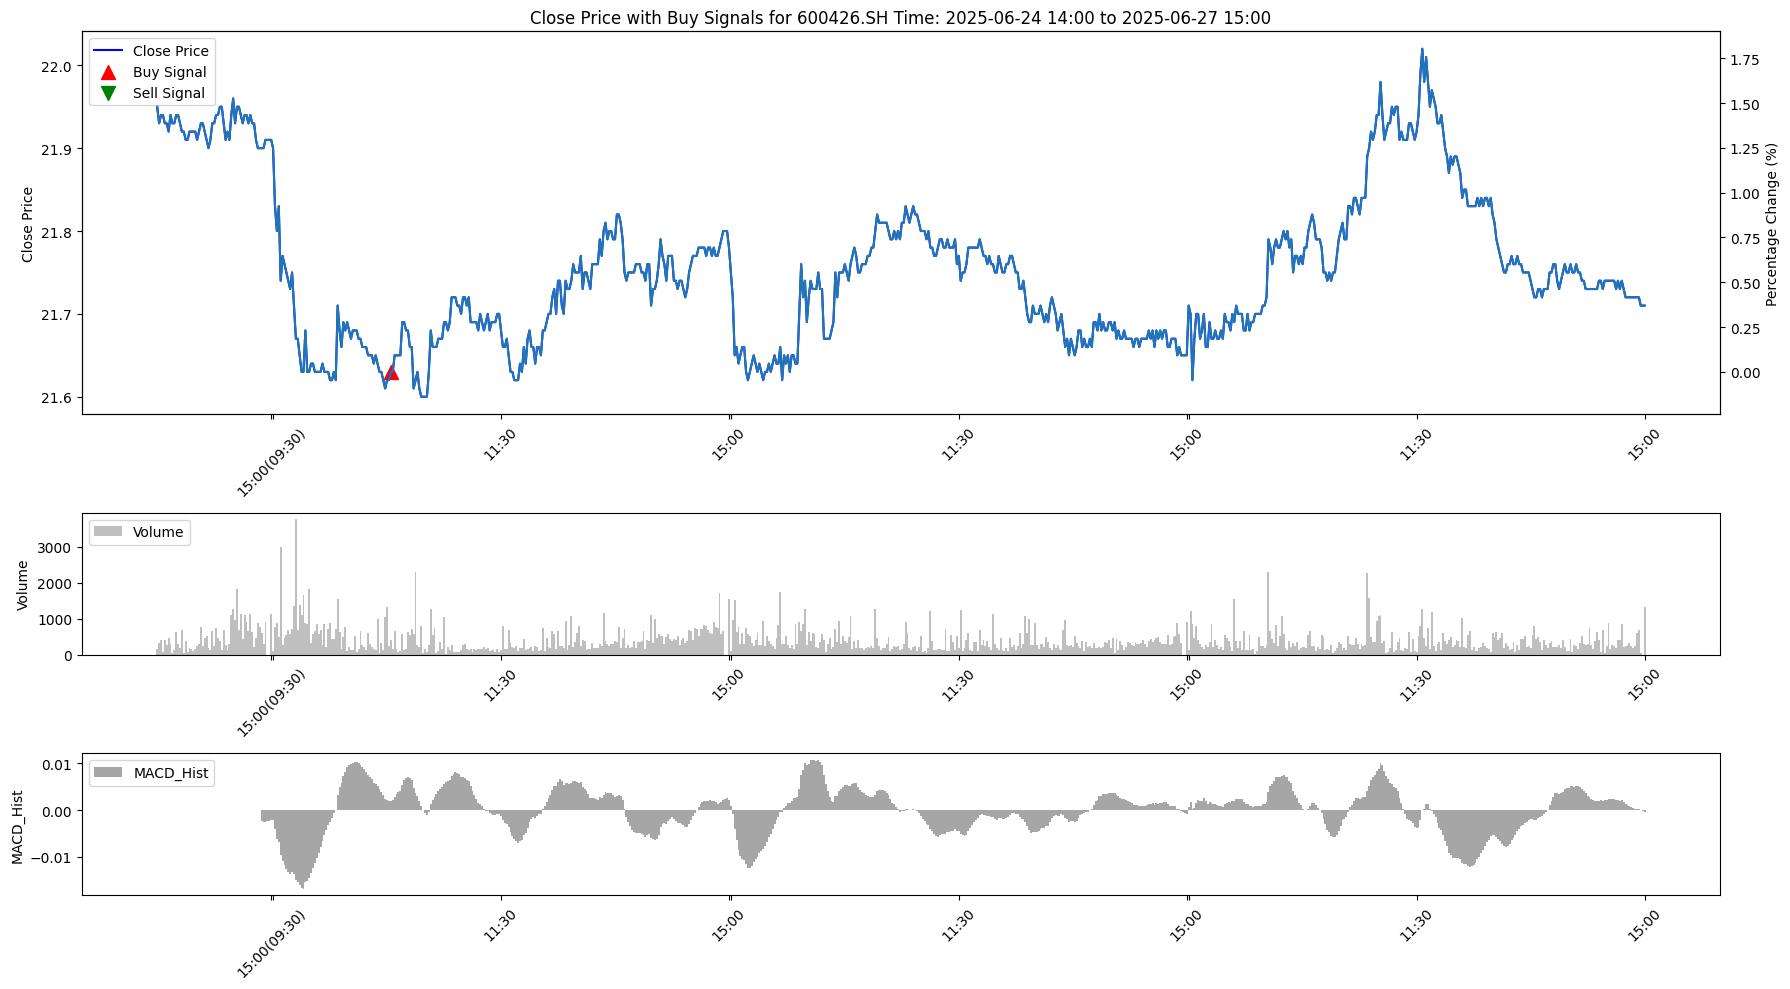

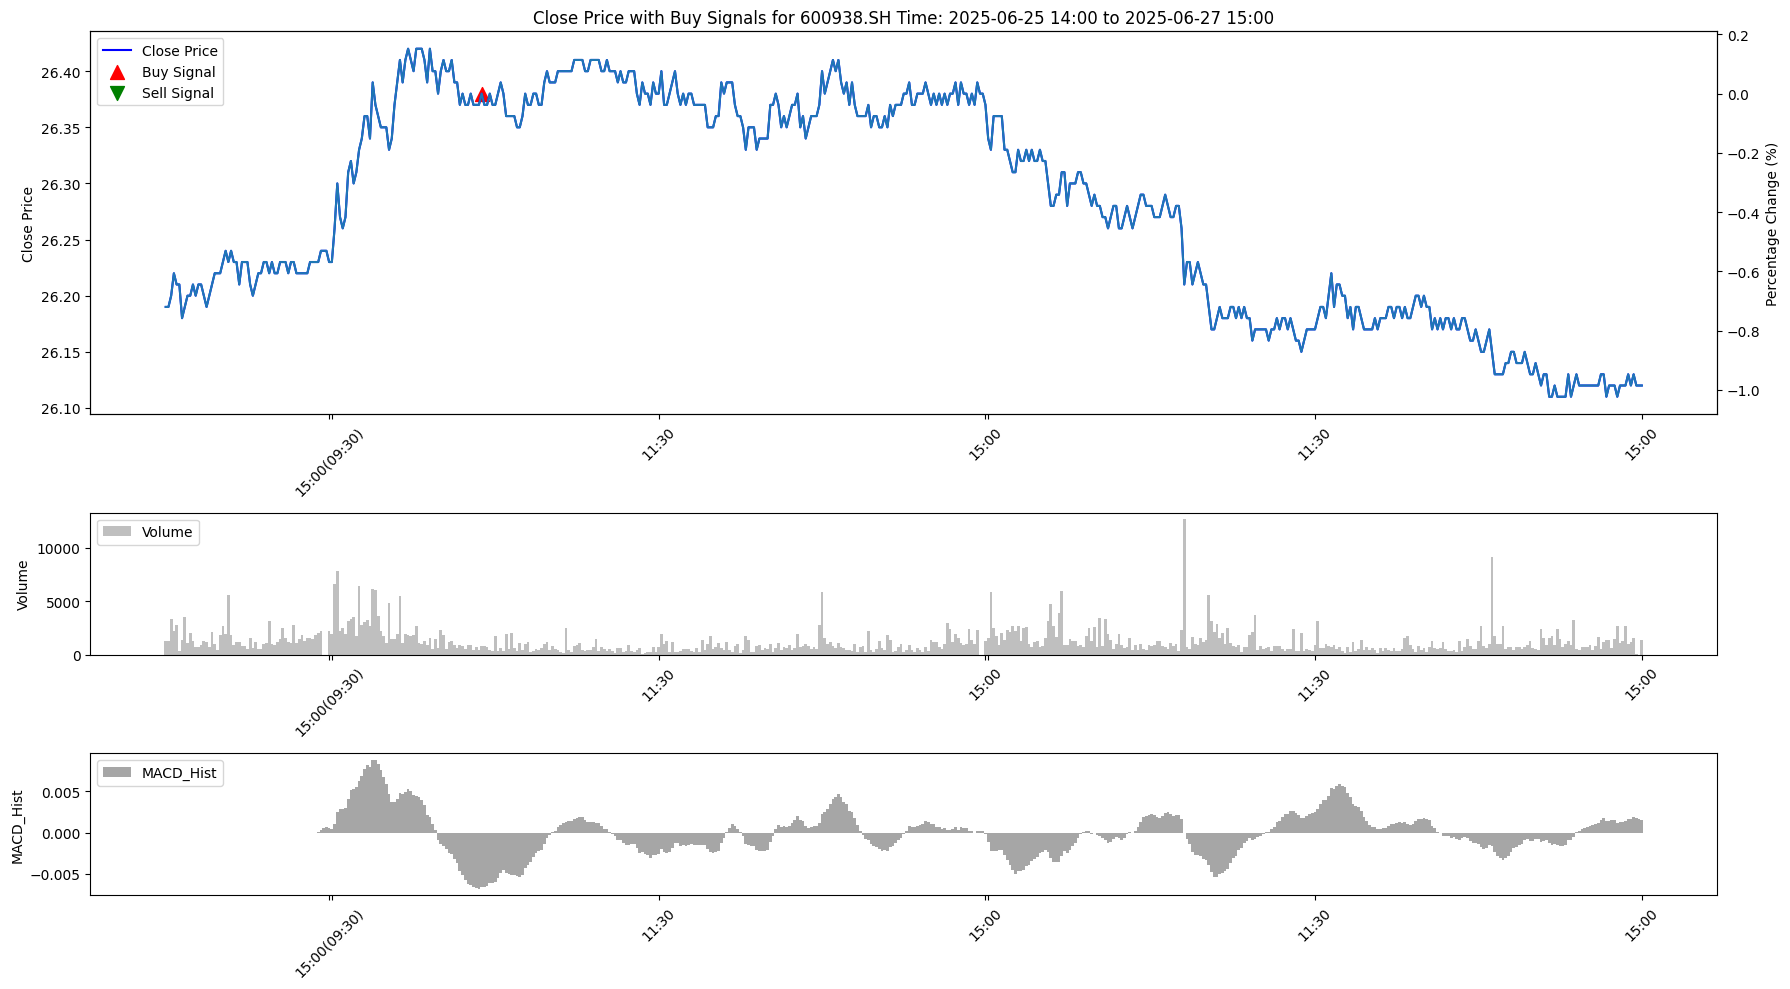

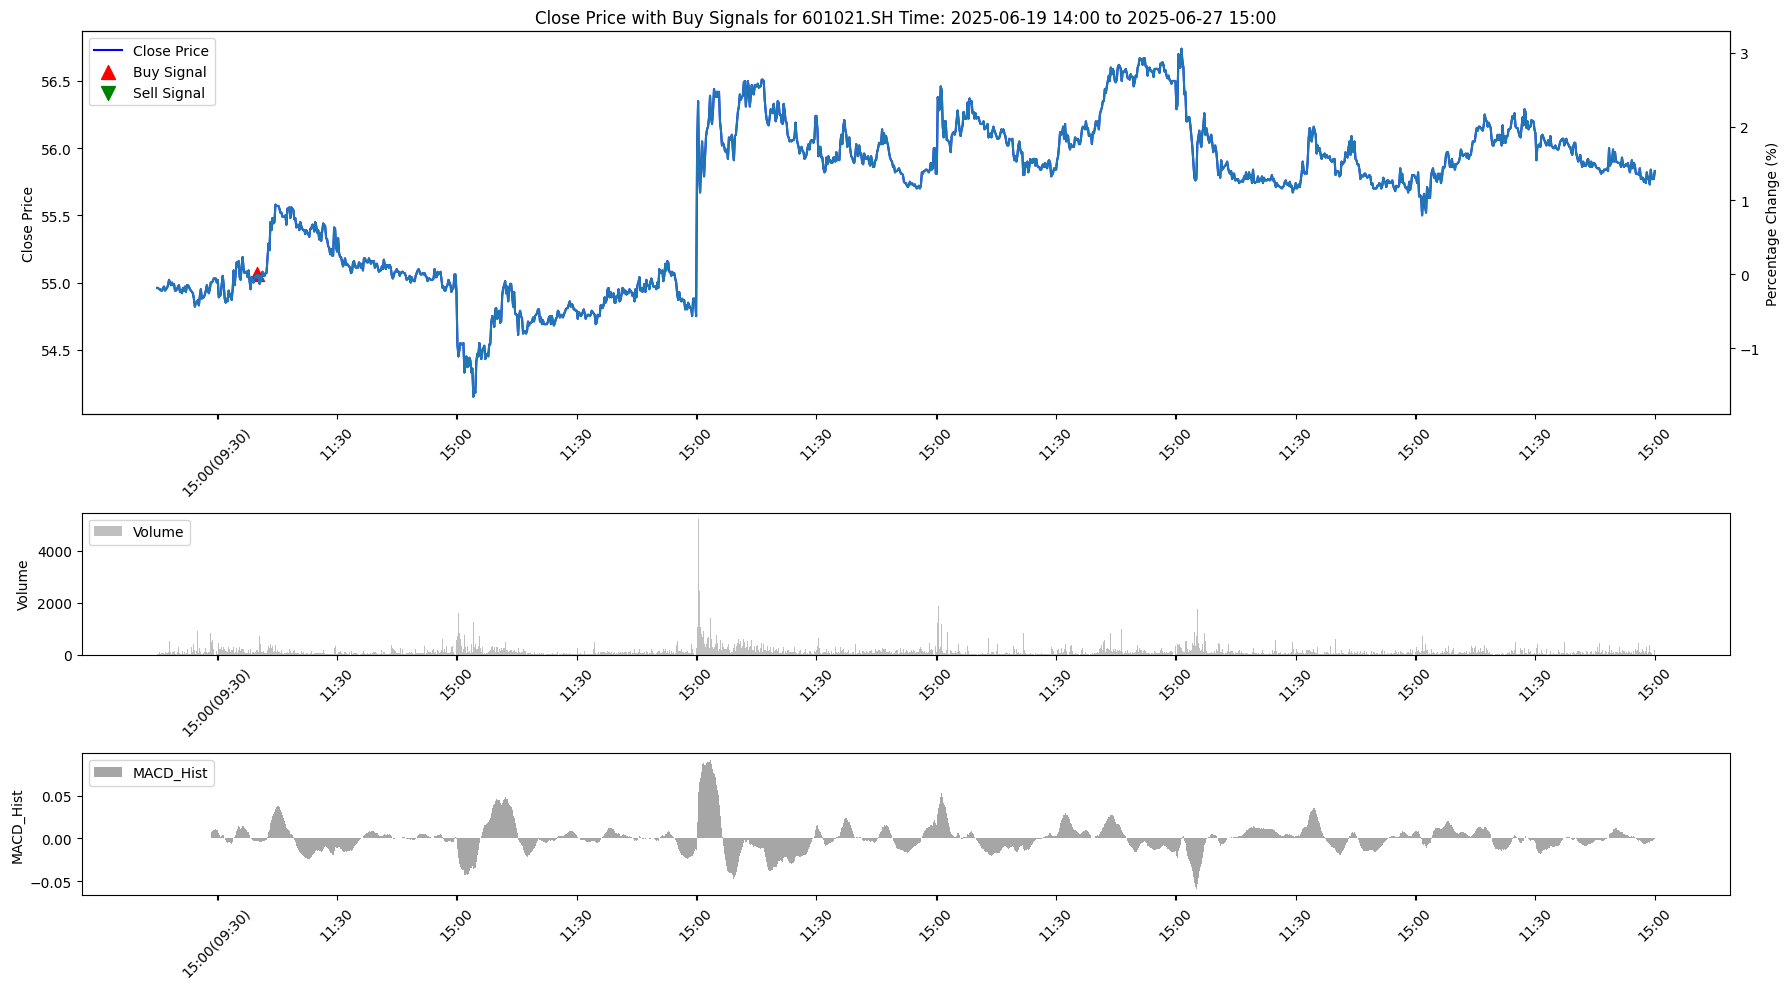

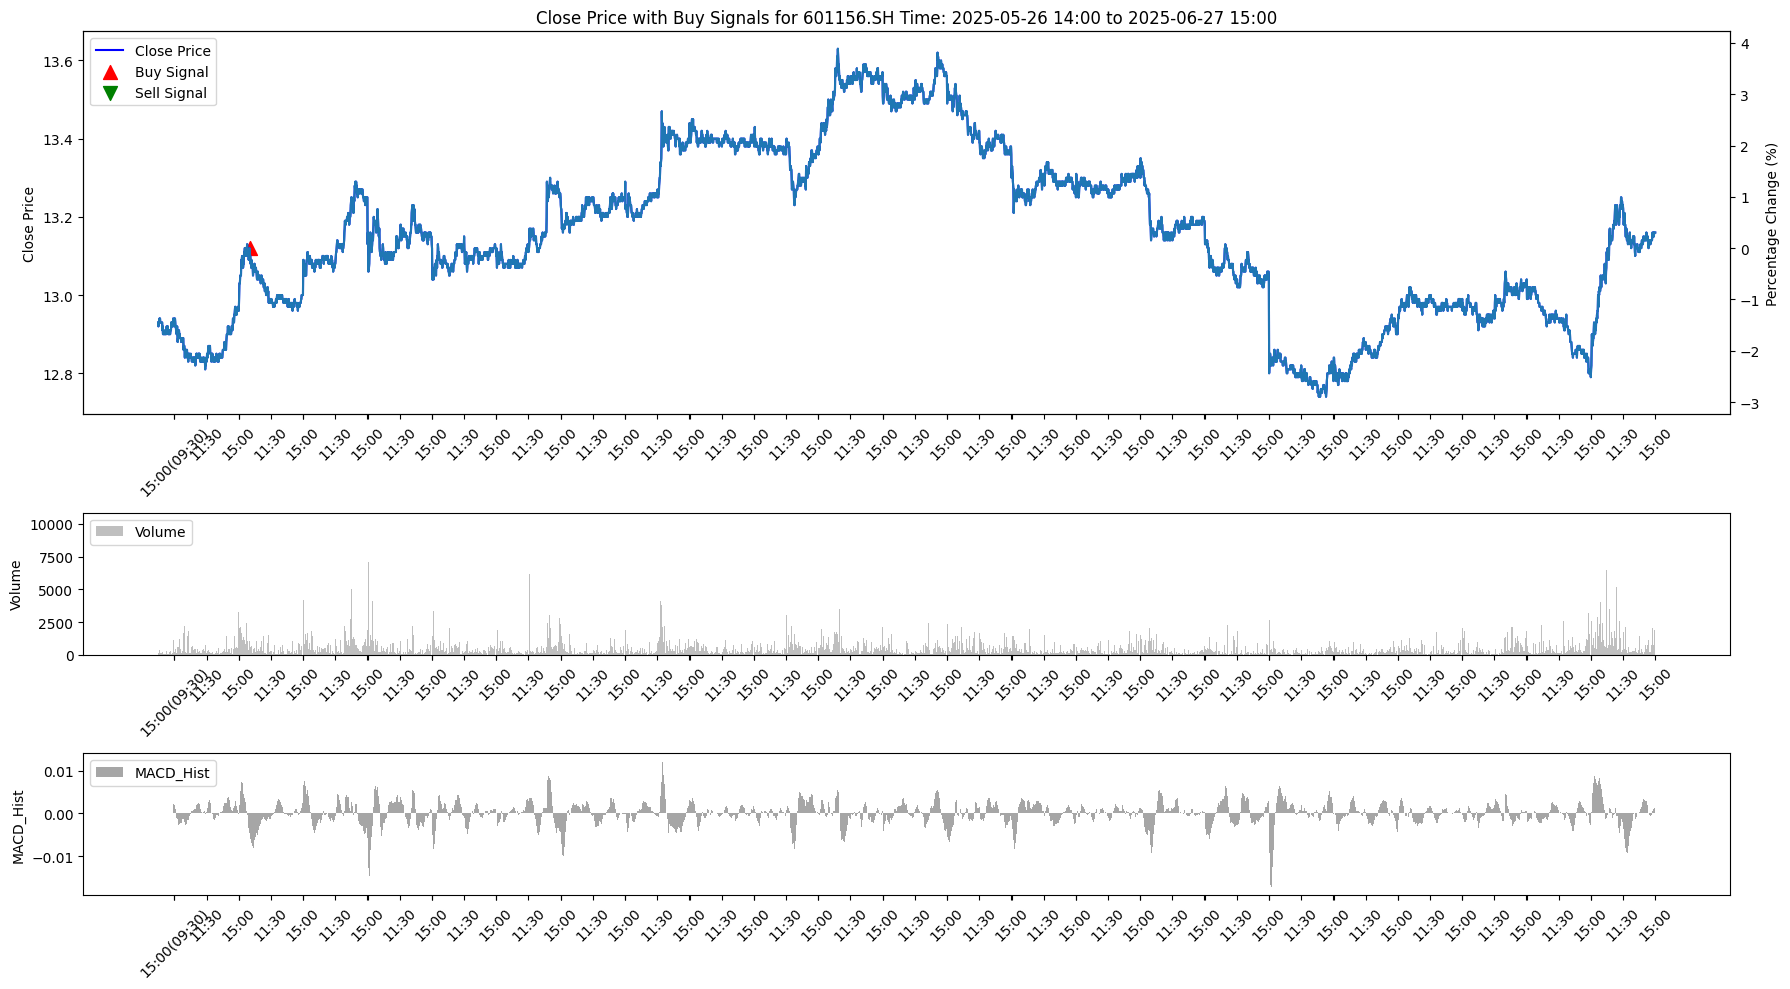

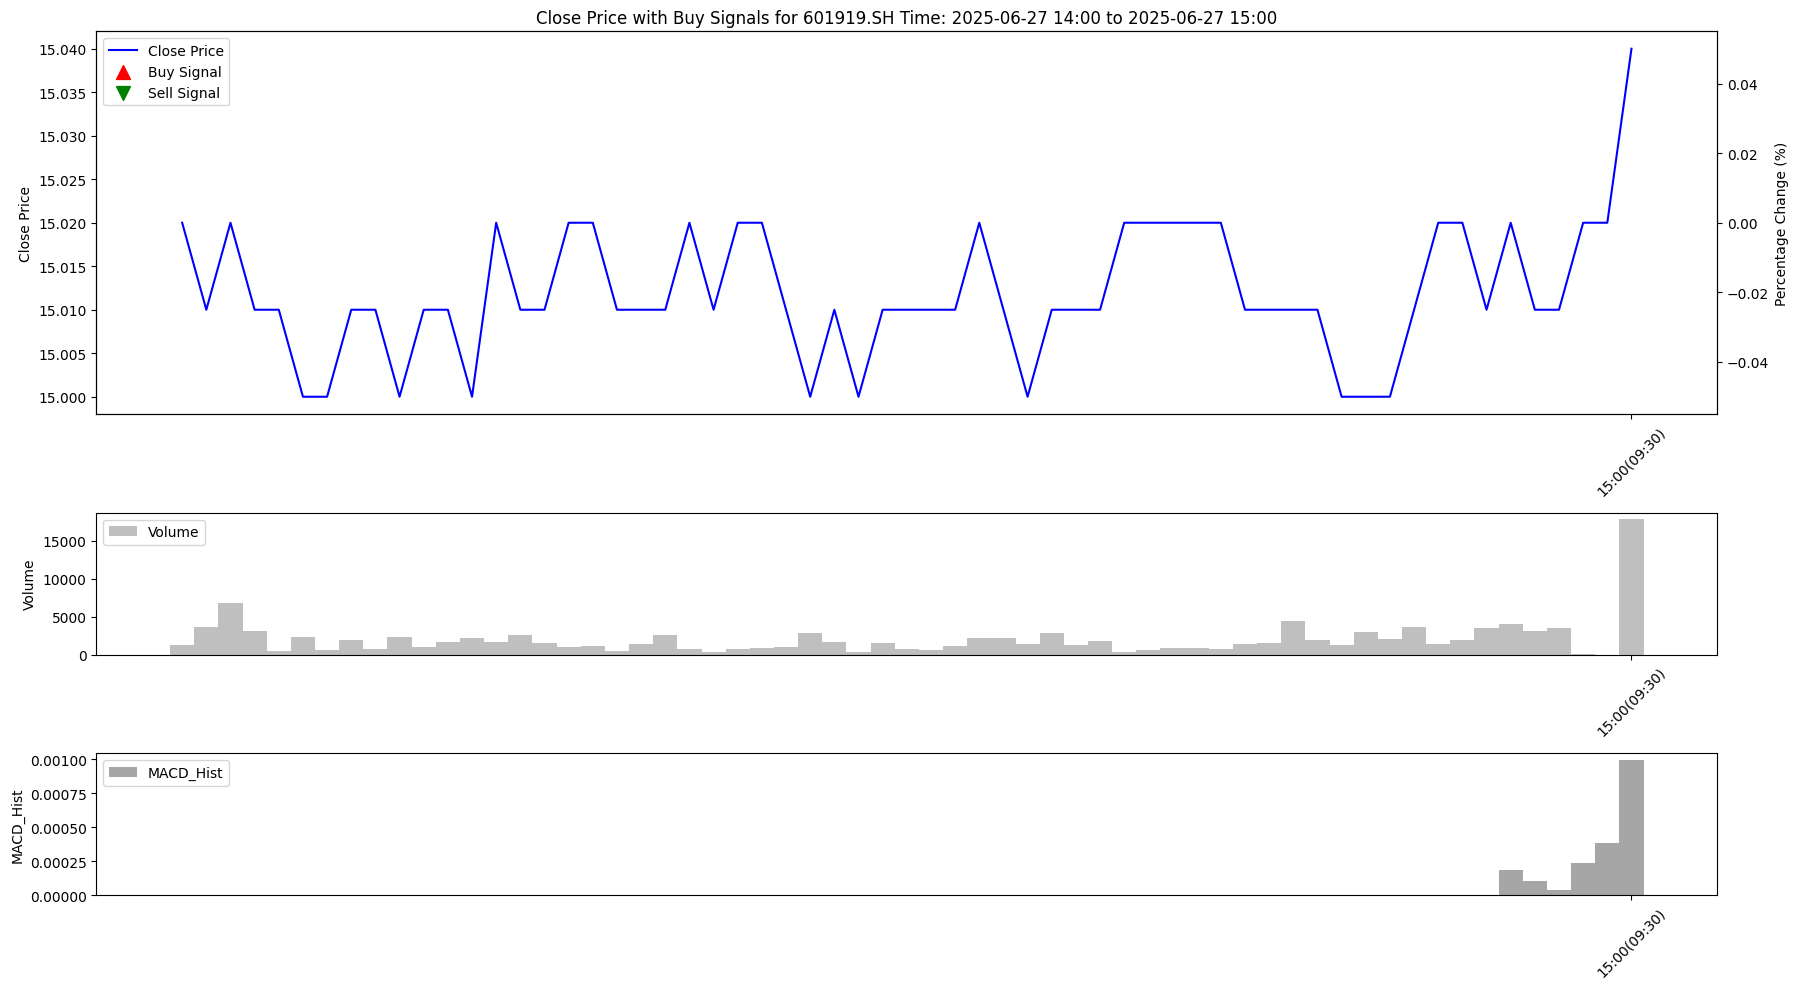

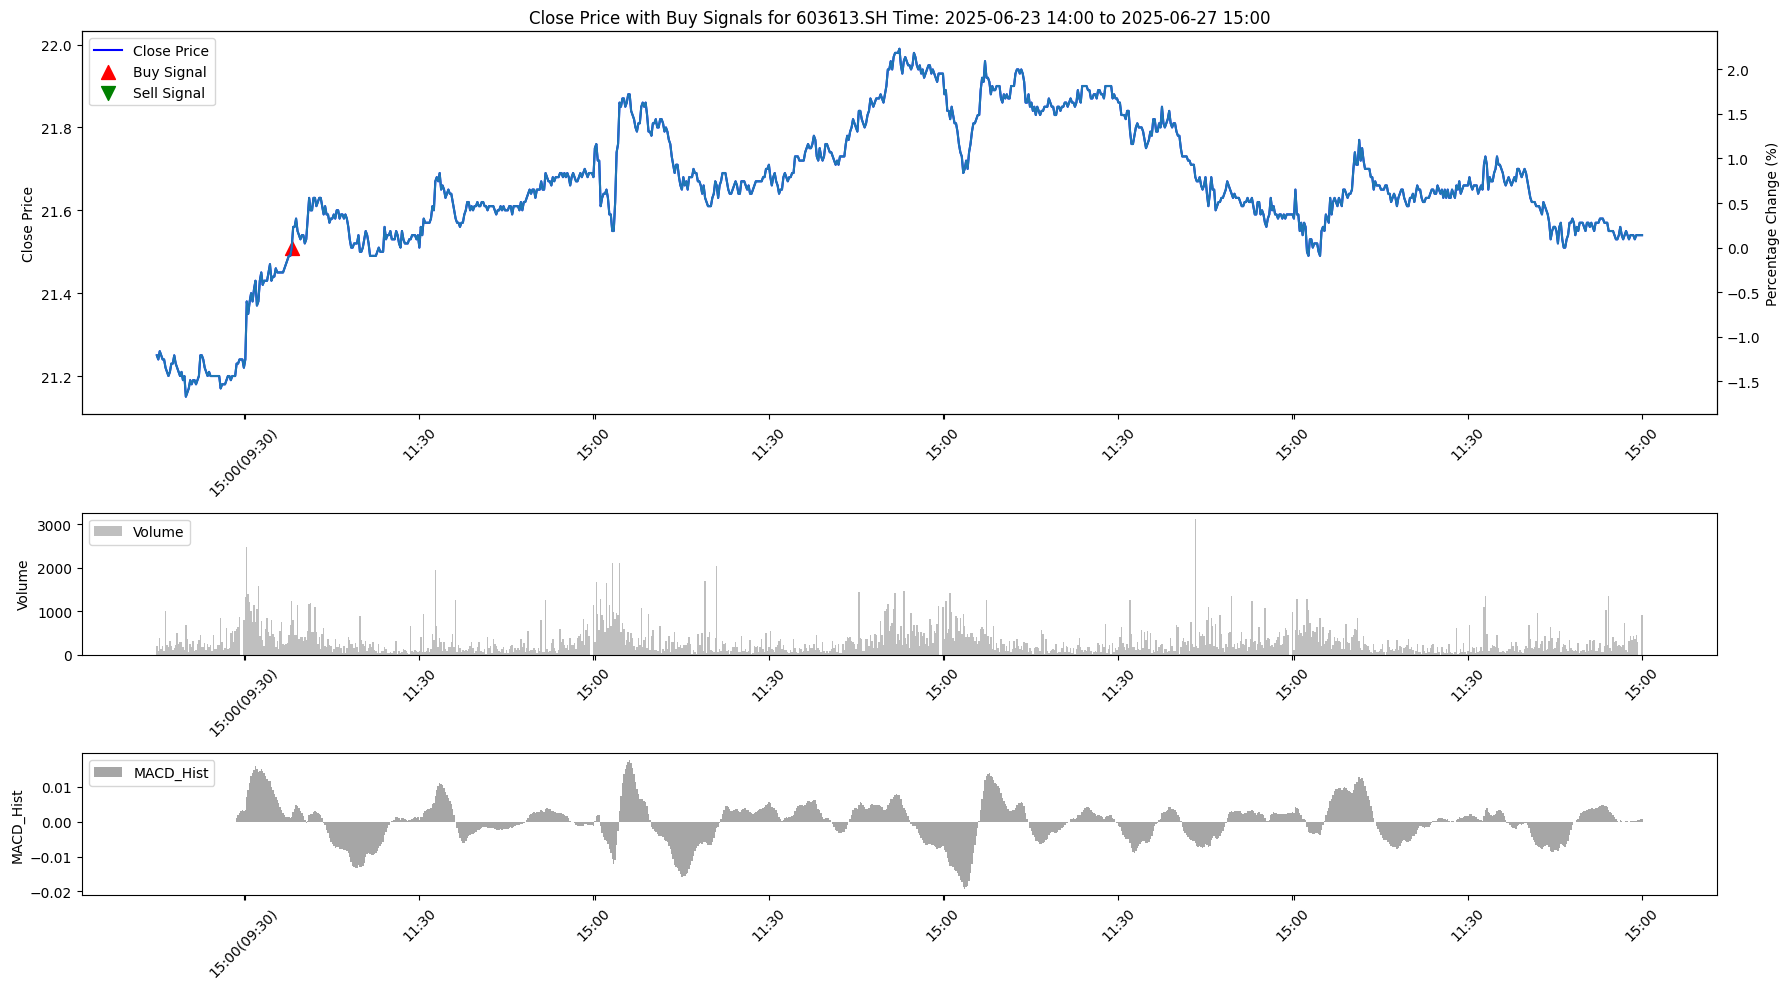

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 加载数据并添加新列
df = pd.read_csv('C:\\Python\\Vanyosr_Strategy\\Min_Signal\\Signal_1m.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y%m%d%H%M%S')

# 设定关键时间点
key_times = ['0930', '1130', '1300', '1500']
df['TimeStr'] = df['Datetime'].dt.strftime('%H%M')  # 提取时间的小时和分钟部分作为字符串

# 按股票代码分组并处理每组数据
def process_group(group):
    group['Index'] = range(1, len(group) + 1)  # 添加从1开始的递增整数列
    buy_price = group.loc[group['Signal'] == 'B', 'close'].values[0] if not group[group['Signal'] == 'B'].empty else None
    if buy_price is not None:
        group['Percent_Change'] = ((group['close'] - buy_price) / buy_price) * 100
    else:
        group['Percent_Change'] = None
    return group

# 应用处理函数并更新df，重置索引
df = df.groupby('stock_code').apply(process_group).reset_index(drop=True)

# 绘图
for name, group in df.groupby('stock_code'):
    # 创建图形和两个子图区域，使用 GridSpec调整大小
    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(4, 1, figure=fig)  # 调整为4行
    ax1 = fig.add_subplot(gs[:2, 0])  # 分配更多空间给close曲线图
    ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)  # 将ax2与ax1共享x轴
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # 新增ax3用于绘制volume

    # 绘制 'close' 折线图
    ax1.plot(group['Index'], group['close'], color='blue', linewidth=1.5)

    # 绘制 'volume' 柱状图
    ax3.bar(group['Index'], group['volume'], color='grey', alpha=0.5, width=1.0)
    ax3.set_ylabel("Volume")
    ax3.legend(['Volume'], loc="upper left")

    # 标记买入信号
    buy_signals = group[group['Signal'] == 'B'][['Index', 'close']]
    ax1.scatter(buy_signals['Index'], buy_signals['close'], color='red', marker='^', s=100)

    # 标记 'S', 'T' 或 'K' 信号
    sell_signals = group[group['Signal'].isin(['S', 'T', 'K'])]
    ax1.scatter(sell_signals['Index'], sell_signals['close'], color='green', marker='v', s=100)

    # 设置主图的标签和标题
    ax1.set_ylabel("Close Price")
    start_date = group['Datetime'].min().strftime('%Y-%m-%d %H:%M')
    end_date = group['Datetime'].max().strftime('%Y-%m-%d %H:%M')
    ax1.set_title(f"Close Price with Buy Signals for {name} Time: {start_date} to {end_date}")
    ax1.legend(['Close Price', 'Buy Signal', 'Sell Signal'], loc="upper left")

    # 绘制 MACD_Hist 柱状图
    ax2.bar(group['Index'], group['MACD_Hist'], color='grey', alpha=0.7, width=1.0)
    ax2.set_ylabel("MACD_Hist")
    ax2.legend(['MACD_Hist'], loc="upper left")

    # 添加辅助 y 轴以显示涨幅百分比
    ax4 = ax1.twinx()
    ax4.plot(group['Index'], group['Percent_Change'])
    ax4.set_ylabel("Percentage Change (%)")

    # 提取符合关键时间的索引并设置 x 轴刻度
    key_indices = group[group['TimeStr'].isin(key_times)]['Index']
    key_labels = group[group['TimeStr'].isin(key_times)]['Datetime'].dt.strftime('%H:%M')

    # 替换15:00的标签并隐藏 09:30
    key_labels = key_labels.tolist()
    if '15:00' in key_labels or '09:30' in key_labels:
        key_labels[key_labels.index('15:00')] = '15:00(09:30)'

    # 设置只显示15:00(09:30)并隐藏 09:30
    key_labels = [label if label != '09:30' else '' for label in key_labels]

    ax1.set_xticks(key_indices)  # 设定关键时间的索引为刻度
    ax2.set_xticks(key_indices)
    ax3.set_xticks(key_indices)
    ax1.set_xticklabels(key_labels, rotation=45)  # 设置关键时间的格式
    ax2.set_xticklabels(key_labels, rotation=45)
    ax3.set_xticklabels(key_labels, rotation=45)
    plt.tight_layout()
    plt.show()

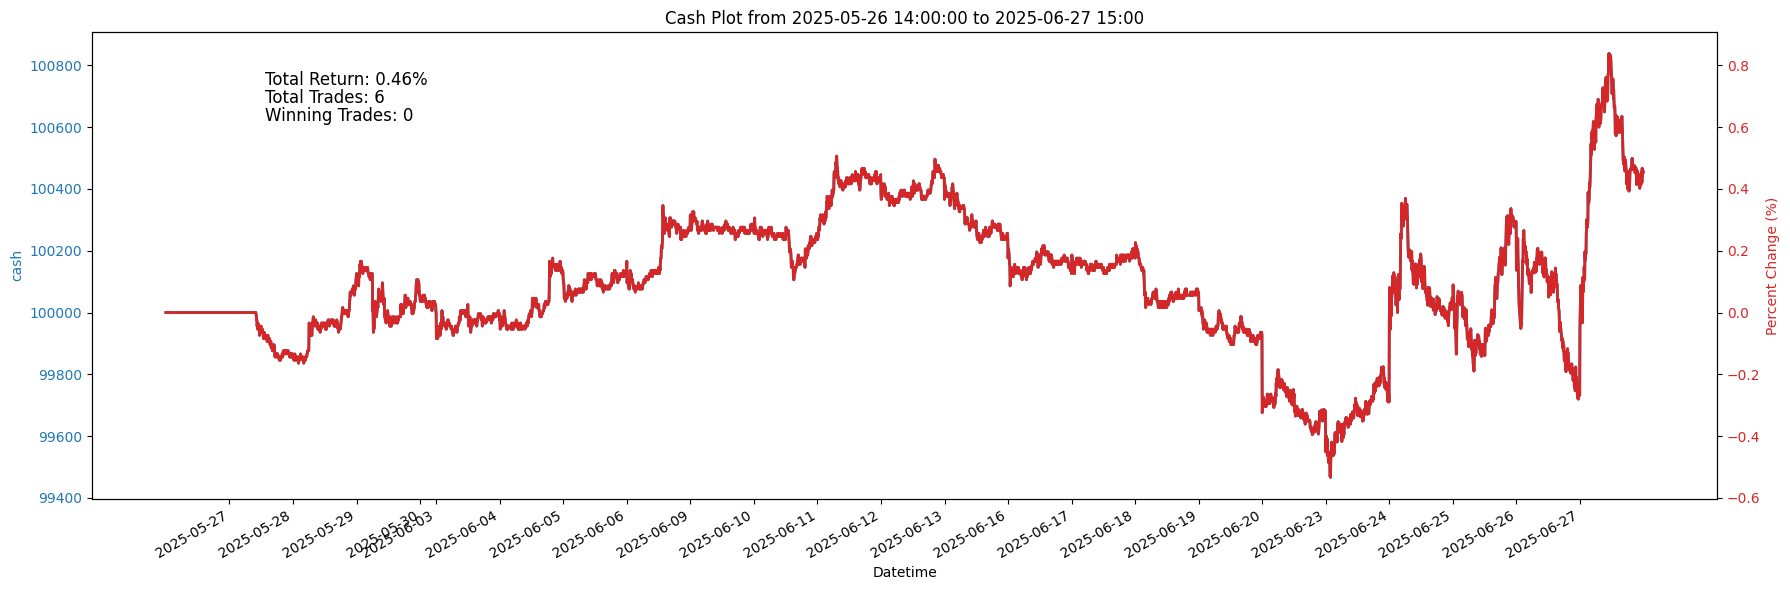

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime, timedelta

# 读取数据
def read_data(file_path, trade_log_path):
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H%M%S')
    trade_log = pd.read_csv(trade_log_path)
    trade_log['date'] = pd.to_datetime(trade_log['date'], format='%Y%m%d%H%M%S')
    return data, trade_log

# 定义计算函数
def calculate_metrics(data, trade_log):
    initial_cash = data['total_cash'].iloc[0]
    final_cash = data['total_cash'].iloc[-1]
    total_return = (final_cash - initial_cash) / initial_cash
    total_trades = trade_log['action'].count()
    wins = sum((trade_log['action'] == 'sell') & (trade_log['price'] > trade_log['price'].shift(1)))
    return total_return, total_trades, wins

# 绘制资金曲线图
def plot_cash_curve(data, metrics):
    fig, ax1 = plt.subplots(figsize=(18, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('cash', color=color)
    ax1.plot(range(len(data)), data['total_cash'], marker='', linestyle='-', linewidth=2, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(False)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Percent Change (%)', color=color)
    ax2.plot(range(len(data)), data['percent_change'], marker='', linestyle='-', linewidth=2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    # 添加交易日期范围
    start_date = data['date'].iloc[0].strftime('%Y-%m-%d %H:%M')
    end_date = data['date'].iloc[-1].strftime('%Y-%m-%d %H:%M')
 

    # 设置 x 轴的刻度和标签
    start_date = data['date'].iloc[0]
    key_indices = []
    key_labels = []
    current_date = start_date
    for i, row in enumerate(data.itertuples()):
        if (row.date - current_date).days >= 1:
            key_indices.append(i)
            key_labels.append(row.date.strftime('%Y-%m-%d'))
            current_date = row.date

    ax1.xaxis.set_major_locator(mtick.FixedLocator(key_indices))
    ax1.xaxis.set_major_formatter(mtick.FixedFormatter(key_labels))
    fig.autofmt_xdate()

    # 显示指标
    plt.figtext(0.15, 0.85, f'Total Return: {metrics[0]:.2%}', fontsize=12, color='black')
    plt.figtext(0.15, 0.82, f'Total Trades: {metrics[1]}', fontsize=12, color='black')
    plt.figtext(0.15, 0.79, f'Winning Trades: {metrics[2]}', fontsize=12, color='black')
    plt.title(f'Cash Plot from {start_date} to {end_date}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 主函数
def main():
    file_path = r'C:\Python\Vanyosr_Strategy\Min_Signal\total_cash_log_1m.csv'
    trade_log_path = r'C:\Python\Vanyosr_Strategy\Min_Signal\trade_log_1m.csv'
    data, trade_log = read_data(file_path, trade_log_path)
    data['percent_change'] = (data['total_cash'] - data['total_cash'].iloc[0]) / data['total_cash'].iloc[0] * 100
    metrics = calculate_metrics(data, trade_log)
    plot_cash_curve(data, metrics)

if __name__ == "__main__":
    main()